## ThinkDSP

This notebook contains solutions to exercises in Chapter 2: Harmonics

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
from thinkdsp import decorate

### Exercise 1

A sawtooth signal has a waveform that ramps up linearly from -1 to 1, then drops to -1 and repeats. See http://en.wikipedia.org/wiki/Sawtooth_wave

Write a class called `SawtoothSignal` that extends `Signal` and provides `evaluate` to evaluate a sawtooth signal.

Compute the spectrum of a sawtooth wave. How does the harmonic structure compare to triangle and square waves? 

### Solution

My solution is basically a simplified version of TriangleSignal.

In [3]:
from thinkdsp import Sinusoid
from thinkdsp import normalize, unbias
import numpy as np

class SawtoothSignal(Sinusoid):
    """Represents a sawtooth signal."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        cycles = self.freq * ts + self.offset / np.pi / 2
        frac, _ = np.modf(cycles)
        ys = normalize(unbias(frac), self.amp)
        return ys

Here's what it sounds like:

In [4]:
sawtooth = SawtoothSignal().make_wave(duration=0.5, framerate=40000)
sawtooth.make_audio()

And here's what the spectrum looks like:

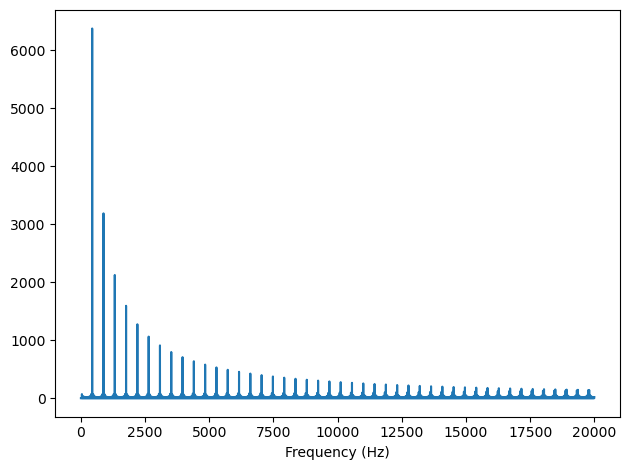

In [5]:
sawtooth.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

Compared to a square wave, the sawtooth drops off similarly, but it includes both even and odd harmonics.  Notice that I had to cut the amplitude of the square wave to make them comparable.

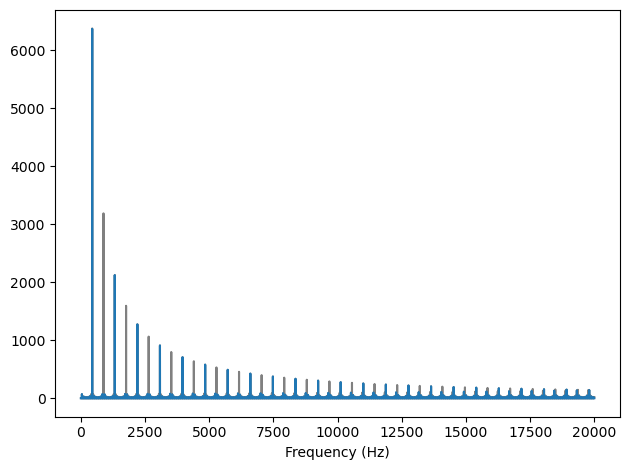

In [6]:
from thinkdsp import SquareSignal

sawtooth.make_spectrum().plot(color='gray')
square = SquareSignal(amp=0.5).make_wave(duration=0.5, framerate=40000)
square.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

Compared to a triangle wave, the sawtooth doesn't drop off as fast.

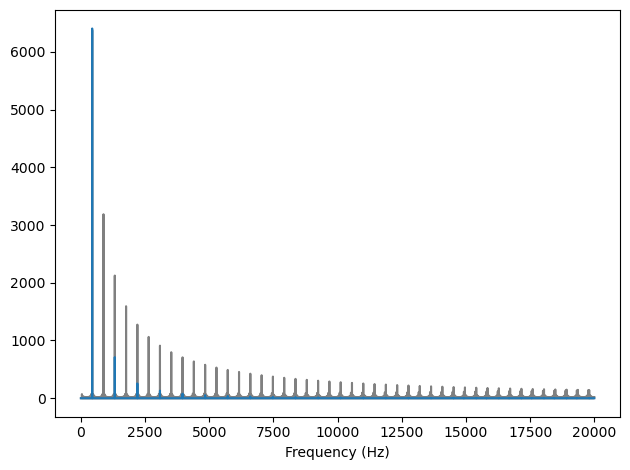

In [7]:
from thinkdsp import TriangleSignal

sawtooth.make_spectrum().plot(color='gray')
triangle = TriangleSignal(amp=0.79).make_wave(duration=0.5, framerate=40000)
triangle.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

Specifically, the harmonics of the triangle wave drop off in proportion to $1/f^2$, while the sawtooth drops off like $1/f$.

### Exercise 2

Make a square signal at 1500 Hz and make a wave that samples it
at 10000 frames per second.  If you plot the spectrum, you can
see that most of the harmonics are aliased.
When you listen to the wave, can you hear the aliased harmonics? 

### Solution

Here's the square wave:

In [8]:
square = SquareSignal(1500).make_wave(duration=0.5, framerate=10000)

Here's what the spectrum looks like:

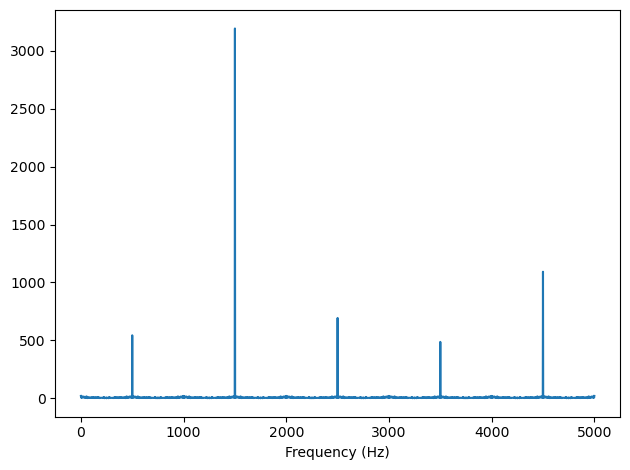

In [9]:
square.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

You can see the fundamental at 1500 Hz and the first harmonic at 4500 Hz, but the second harmonic, which should be at 7500 Hz, is aliased to 2500 Hz.

The third harmonic, which should be at 10500 Hz, would get aliased to -500 Hz, but that gets aliased again to 500 Hz.

And the 4th harmonic, which should be at 13500 Hz, ends up at 3500 Hz.

The 5th harmonic, which should be at 16500 Hz, ends up at 1500 Hz, so it contributes to the fundamental.

The remaining harmonics overlap with the ones we've already seen.

When you listen to the wave, the fundamental pitch you perceive is the alias at 500 Hz.

In [10]:
square.make_audio()

If you compare it to this 500 Hz sine wave, you might hear what I mean.

In [11]:
from thinkdsp import SinSignal

SinSignal(500).make_wave(duration=0.5, framerate=10000).make_audio()

### Exercise 3

If you have a spectrum object, `spectrum`, and print the first few values of `spectrum.fs`, you’ll see that the frequencies start at zero. So `spectrum.hs[0]` is the magnitude of the component with frequency 0. But what does that mean?

Try this experiment:

1.    Make a triangle signal with frequency 440 and make a Wave with duration 0.01 seconds. Plot the waveform.
2.    Make a Spectrum object and print `spectrum.hs[0]`. What is the amplitude and phase of this component?
3.    Set `spectrum.hs[0] = 100`. Make a Wave from the modified Spectrum and plot it. What effect does this operation have on the waveform?

### Solution

Here's the triangle wave:

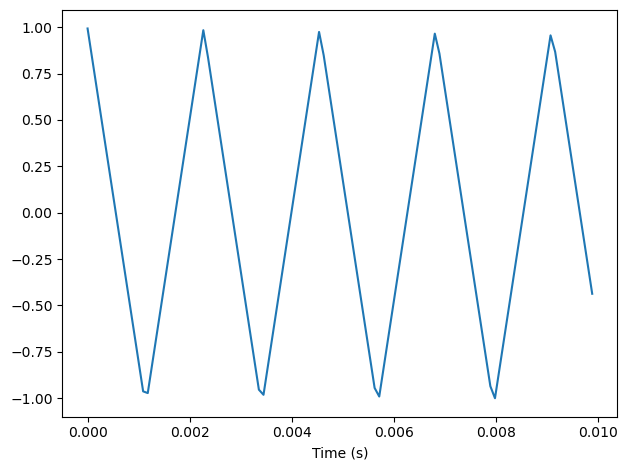

In [12]:
triangle = TriangleSignal().make_wave(duration=0.01)
triangle.plot()
decorate(xlabel='Time (s)')

The first element of the spectrum is a complex number close to zero.

In [13]:
spectrum = triangle.make_spectrum()
spectrum.hs[0]

(1.0436096431476471e-14+0j)

If we add to the zero-frequency component, it has the effect of adding a vertical offset to the wave.

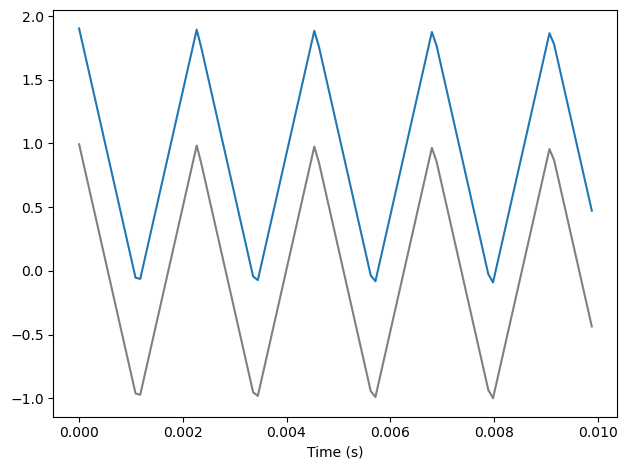

In [14]:
spectrum.hs[0] = 100
triangle.plot(color='gray')
spectrum.make_wave().plot()
decorate(xlabel='Time (s)')

The zero-frequency component is the total of all the values in the signal, as we'll see when we get into the details of the DFT.  If the signal is unbiased, the zero-frequency component is 0.  In the context of electrical signals, the zero-frequency term is called the DC offset; that is, a direct current offset added to an AC signal.

### Exercise 4

Write a function that takes a Spectrum as a parameter and modifies it by dividing each element of hs by the corresponding frequency from fs. Test your function using one of the WAV files in the repository or any Wave object.

1. Compute the Spectrum and plot it.
2. Modify the Spectrum using your function and plot it again.
3. Make a Wave from the modified Spectrum and listen to it. What effect does this operation have on the signal?

### Solution

Here's my version of the function:

In [15]:
def filter_spectrum(spectrum):
    """Divides the spectrum through by the fs.
    
    spectrum: Spectrum object
    """
    # avoid division by 0
    spectrum.hs[1:] /= spectrum.fs[1:]
    spectrum.hs[0] = 0

Here's a triangle wave:

In [16]:
wave = TriangleSignal(freq=440).make_wave(duration=0.5)
wave.make_audio()

Here's what the before and after look like.  I scaled the after picture to make it visible on the same scale.

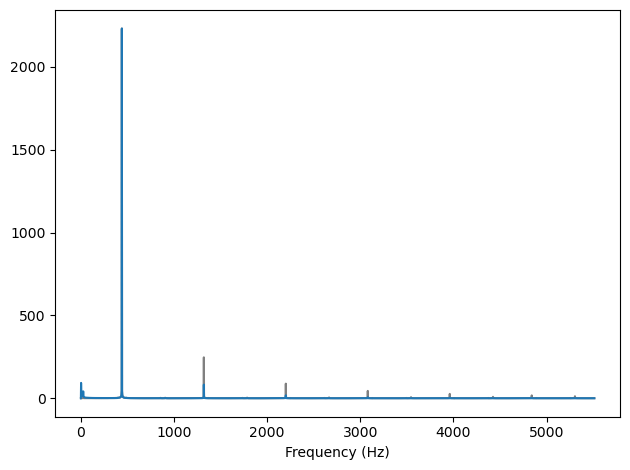

In [17]:
spectrum = wave.make_spectrum()
spectrum.plot(high=10000, color='gray')
filter_spectrum(spectrum)
spectrum.scale(440)
spectrum.plot(high=10000)
decorate(xlabel='Frequency (Hz)')

The filter clobbers the harmonics, so it acts like a low pass filter.

Here's what it sounds like:

In [18]:
filtered = spectrum.make_wave()
filtered.make_audio()

The triangle wave now sounds almost like a sine wave.

### Exercise 5

The triangle and square waves have odd harmonics only; the sawtooth wave has both even and odd harmonics. The harmonics of the square and sawtooth waves drop off in proportion to $1/f$; the harmonics of the triangle wave drop off like $1/f^2$. Can you find a waveform that has even and odd harmonics that drop off like $1/f^2$?

Hint: There are two ways you could approach this: you could
construct the signal you want by adding up sinusoids, or you
could start with a signal that is similar to what you want and
modify it.

### Solution

One option is to start with a sawtooth wave, which has all of the harmonics we need:

In [19]:
freq = 500
signal = SawtoothSignal(freq=freq)
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

Here's what the spectrum looks like.  The harmonics drop off like $1/f$.

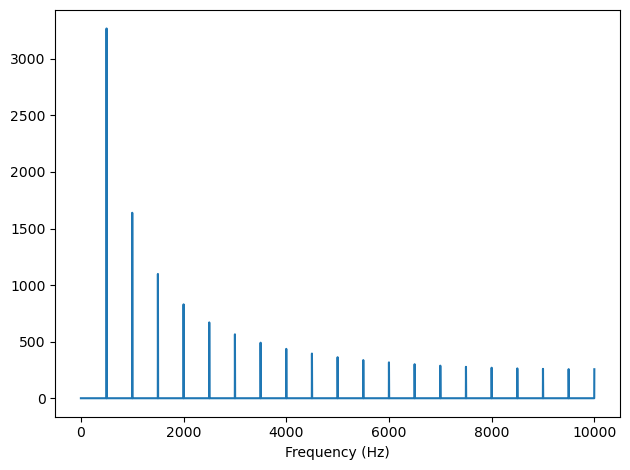

In [20]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

If we apply the filter we wrote in the previous exercise, we can make the harmonics drop off like $1/f^2$.

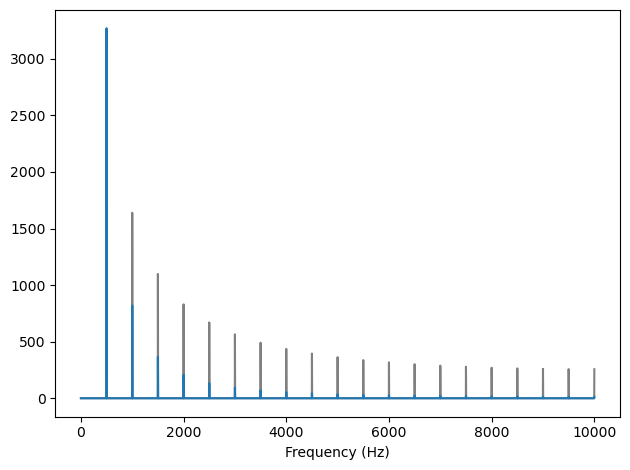

In [21]:
spectrum.plot(color='gray')
filter_spectrum(spectrum)
spectrum.scale(freq)
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Here's what it sounds like:

In [22]:
wave = spectrum.make_wave()
wave.make_audio()

And here's what the waveform looks like.

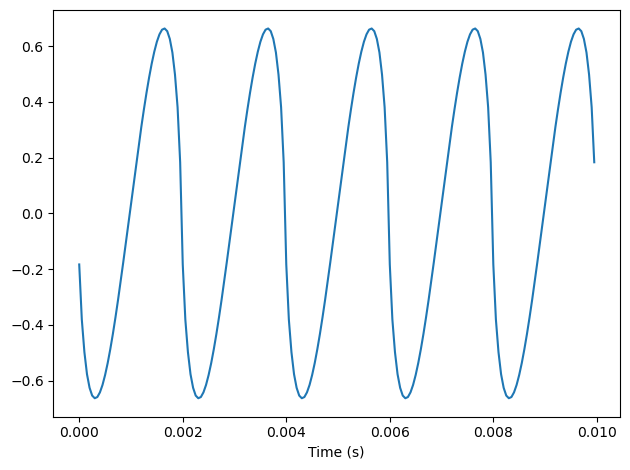

In [23]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

It's an interesting shape, but not easy to see what its functional form is.

Another approach is to add up a series of cosine signals with the right frequencies and amplitudes.

In [24]:
from thinkdsp import CosSignal

freqs = np.arange(500, 9500, 500)
amps = 1 / freqs**2
signal = sum(CosSignal(freq, amp) for freq, amp in zip(freqs, amps))
signal

Here's what the spectrum looks like:

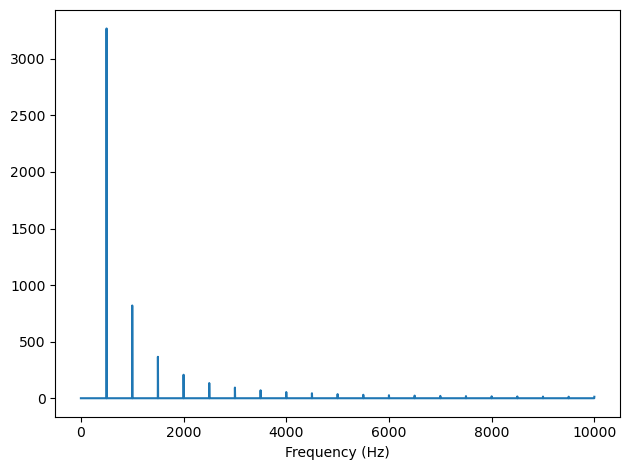

In [25]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Here's what it sounds like:

In [26]:
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

And here's what the waveform looks like.

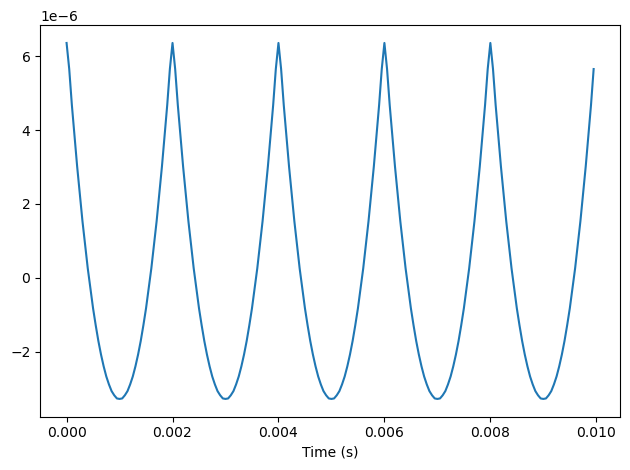

In [27]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

If you think those like parabolas, you might be right.  `thinkdsp` provides `ParabolicSignal`, which computes parabolic waveforms.

In [28]:
from thinkdsp import ParabolicSignal

wave = ParabolicSignal(freq=500).make_wave(duration=0.5, framerate=20000)
wave.make_audio()

Here's what the waveform looks like:

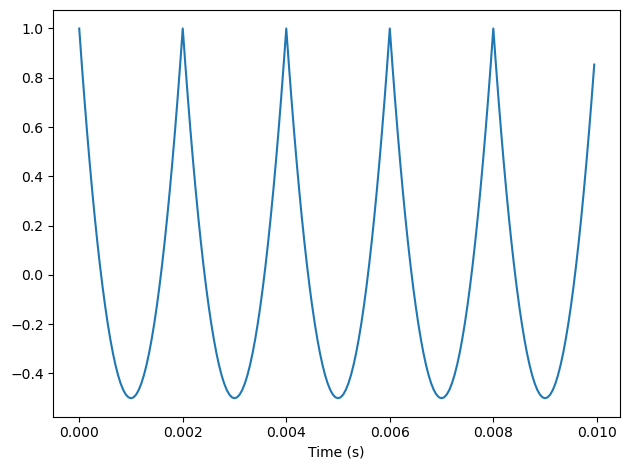

In [29]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

A parabolic signal has even and odd harmonics which drop off like $1/f^2$:

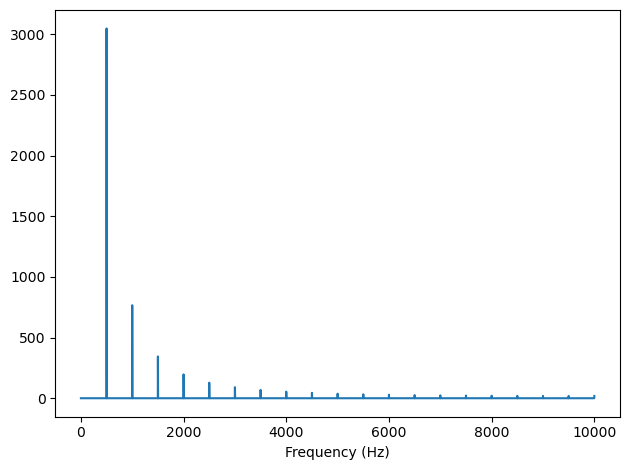

In [30]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')